In [615]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import seaborn as sns
%matplotlib inline
import seaborn as sns
sns.set_theme() 
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [565]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

In [566]:
# reading csv files
data =  pd.read_csv(r"C:\Users\lisac\SeoulBikeData.csv", encoding="latin-1")

#### Renommage des colonnes

In [567]:
data.rename(columns = {'Rented Bike Count':'Rented_bike_count',"Temperature(°C)":'Temperature'}, inplace = True)

In [568]:
data.columns

Index(['Date', 'Rented_bike_count', 'Hour', 'Temperature', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [569]:
data[data.isna()].sum()

Date                           0
Rented_bike_count            0.0
Hour                         0.0
Temperature                  0.0
Humidity(%)                  0.0
Wind speed (m/s)             0.0
Visibility (10m)             0.0
Dew point temperature(°C)    0.0
Solar Radiation (MJ/m2)      0.0
Rainfall(mm)                 0.0
Snowfall (cm)                0.0
Seasons                        0
Holiday                        0
Functioning Day                0
dtype: object

# DATA VIZUALISATIONS

### Nombre de vélos loués selon la saison  

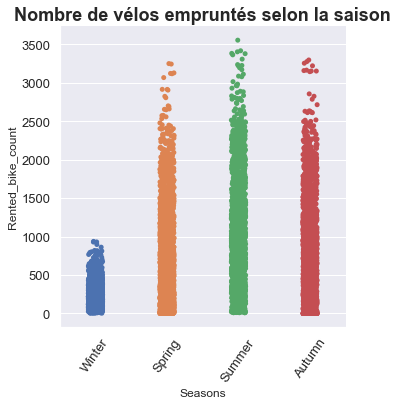

In [390]:
#Nombre de vélos empruntés selon la saison 
sns.catplot(x="Seasons",y="Rented_bike_count",data=data)
fontsize=18
plt.xticks(rotation=55,fontsize = 13)
plt.yticks(fontsize=13)
plt.title("Nombre de vélos empruntés selon la saison",fontweight="bold",fontdict={'fontsize': fontsize});

## Proportions de vélos loués selon la période de vacances/ période de travail 

In [454]:
data_holiday = data.groupby("Holiday").sum()["Rented_bike_count"].reset_index()

In [455]:
data_holiday["Prop"]=data_holiday["Rented_bike_count"]/data_holiday["Rented_bike_count"].sum()

In [456]:
functionning_day_or_not = data["Functioning Day"].value_counts()

trace1 = go.Pie(
     values= data_holiday["Prop"],
     labels=data_holiday["Holiday"],
     hoverinfo="label+percent+name",
)
trace2 = go.Pie(
     values= functionning_day_or_not.values,
     labels= ["Open days","Closed days"],
     hoverinfo="label+percent+name",
)
layout = go.Layout(title="Pourentage de vélos loués selon si c'est les vacances ou non/ jour de travail ou non ",)
data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
py.plot(fig, filename='simple-pie-subplot')

'simple-pie-subplot.html'

#### Récupération du mois de l'année et du jour de la location pour exploitation 

In [570]:
data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Day'] = pd.to_datetime(data['Date']).dt.day
data['Year'] = pd.to_datetime(data['Date']).dt.year

### Nombre de vélos loués selon le mois de l'année

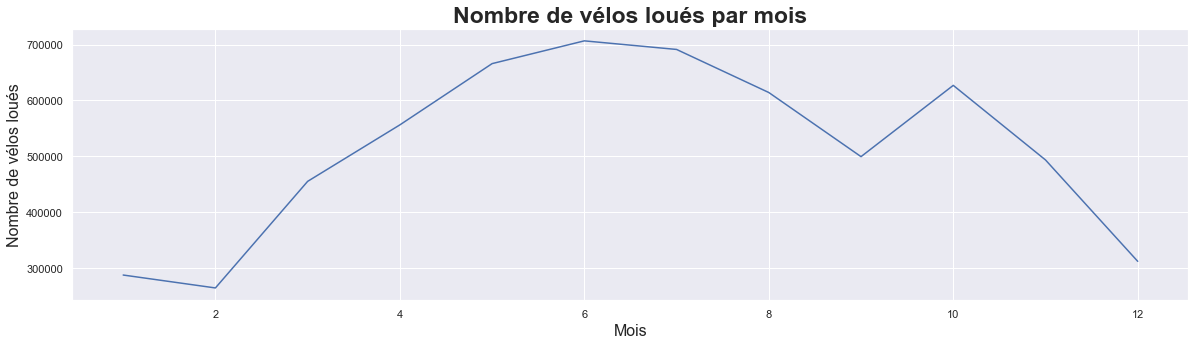

In [571]:

rental_by_month= data.groupby("Month").sum()["Rented_bike_count"].reset_index()
sns.set(rc={'figure.figsize':(20,5)})
sns.lineplot(data=rental_by_month, x="Month", y="Rented_bike_count");
plt.title("Nombre de vélos loués par mois", fontsize=23, fontweight="bold");
plt.xlabel('Mois', fontsize=16);
plt.ylabel('Nombre de vélos loués', fontsize=16);

# Corrélation et analyse statistique

### Matrice des corréaltions

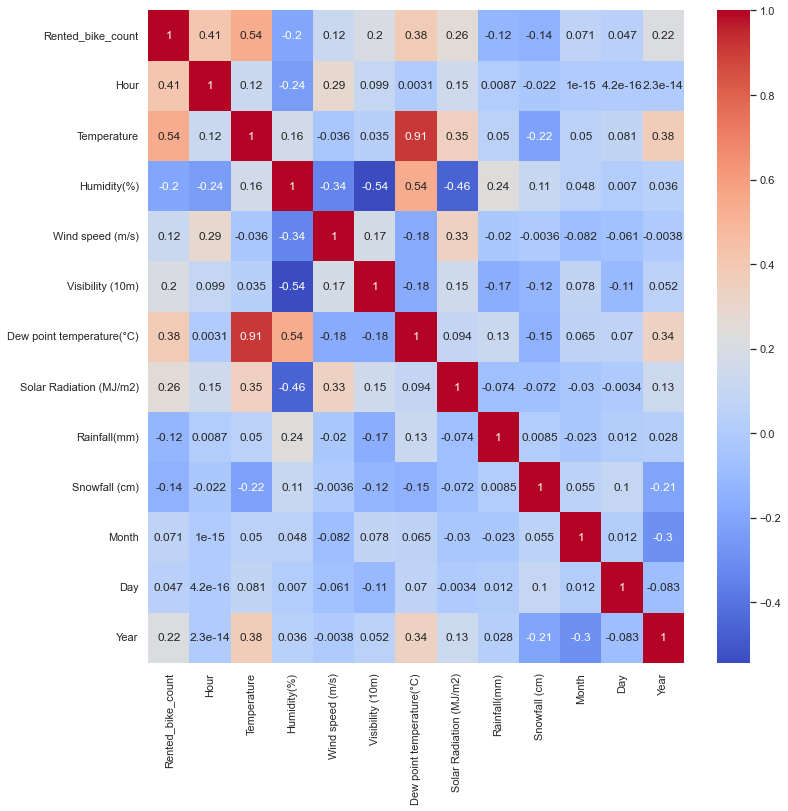

In [340]:
cor = data.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor, annot=True, ax=ax, cmap='coolwarm');

## Dépendance statistique avec la variable target "Rented Bike Count"

### Nous réalisons un test de Pearson entre notre variable Target "Rented Bike Count" et les autres variables quantitatives du dataframe afin d'évaluer la dépendance entre les deux variables

Les p_values sont toutes < 5%, il y a donc une relation significative entre les variables quantitatives de notre DataFrame et la varibale target

In [342]:
from scipy.stats import pearsonr 
columns=["Temperature","Humidity(%)","Wind speed (m/s)","Visibility (10m)","Dew point temperature(°C)","Solar Radiation (MJ/m2)","Rainfall(mm)","Snowfall (cm)"]   
for col in columns:
    print(pd.DataFrame(pearsonr(data["Rented_bike_count"],data[col]),index=["pearson_coef","p_value"],columns=["Resultat"]))

              Resultat
pearson_coef  0.538558
p_value       0.000000
                  Resultat
pearson_coef -1.997802e-01
p_value       1.475065e-79
                  Resultat
pearson_coef  1.211084e-01
p_value       5.544562e-30
                  Resultat
pearson_coef  1.992803e-01
p_value       3.672704e-79
                   Resultat
pearson_coef   3.797881e-01
p_value       1.325584e-298
                   Resultat
pearson_coef   2.618370e-01
p_value       2.780395e-137
                  Resultat
pearson_coef -1.230740e-01
p_value       6.462816e-31
                  Resultat
pearson_coef -1.418036e-01
p_value       1.398012e-40


### Test Anova pour analyser la relation entre les variables qualitatives et la variable target qui est quantitative

Les p-values sont < 5%

In [343]:
import statsmodels.api
result = statsmodels.formula.api.ols('Rented_bike_count ~ Seasons', data = data).fit() 
table = statsmodels.api.stats.anova_lm(result)
table

,df,sum_sq,mean_sq,F,PR(>F)
Seasons,3.0,7.657090e+08,2.552363e+08,776.467815,0.0
Residual,8756.0,2.878225e+09,3.287146e+05,NaN,NaN


In [344]:
import statsmodels.api
result = statsmodels.formula.api.ols('Rented_bike_count ~ Holiday', data = data).fit() 
table = statsmodels.api.stats.anova_lm(result)
table

,df,sum_sq,mean_sq,F,PR(>F)
Holiday,1.0,1.906770e+07,1.906770e+07,46.069261,1.215644e-11
Residual,8758.0,3.624867e+09,4.138921e+05,NaN,NaN


# Machine Learning

In [463]:
import numpy as np

from sklearn import model_selection, preprocessing

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error


In [572]:
# Dummies 
data['Hour'] = data['Hour'].astype(str)
data=data.drop(columns="Date")
data=pd.get_dummies(data,sparse=True)

In [573]:
data

,Rented_bike_count,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month,...,Hour_8,Hour_9,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1,...,0,0,0,0,0,1,0,1,0,1
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1,...,0,0,0,0,0,1,0,1,0,1
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1,...,0,0,0,0,0,1,0,1,0,1
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1,...,0,0,0,0,0,1,0,1,0,1
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,11,...,0,0,1,0,0,0,0,1,0,1
8756,764,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,11,...,0,0,1,0,0,0,0,1,0,1
8757,694,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,11,...,0,0,1,0,0,0,0,1,0,1
8758,712,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,11,...,0,0,1,0,0,0,0,1,0,1


In [478]:
data.columns

Index(['Rented_bike_count', 'Hour', 'Temperature', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
       'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'Holiday_Holiday', 'Holiday_No Holiday', 'Functioning Day_No',
       'Functioning Day_Yes'],
      dtype='object')

In [576]:
# On va subdiviser notre étude sur plusieurs périmètres avec à chaque fois des différentes variables 

dataset=data

dataset1 = data.copy().drop(['Humidity(%)', 'Rainfall(mm)', 'Snowfall (cm)'], axis = 1)  # Sans les variables dont la corrélation est négative

dataset2 =  data[["Rented_bike_count",'Temperature','Dew point temperature(°C)']]  #Avec les variables les plus corrélée à la variable target

In [580]:
X= data.drop(columns = 'Rented_bike_count')
X1 = dataset1.drop(columns = 'Rented_bike_count')
X2= dataset2.drop(columns = "Rented_bike_count")
y = data["Rented_bike_count"]


# Régression linéaire

In [587]:
#Split des données
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=42)
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y, test_size=0.2,random_state=42)
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y, test_size=0.2,random_state=42)

#Scale des données 
def ScaleData(x_train,x_test):
    scaler =  preprocessing.StandardScaler(with_mean=False)
    scaler.fit(x_train)             
    x_train = scaler.transform(x_train, copy = False)
    x_test  = scaler.transform(x_test, copy = False)
    
ScaleData(X_train,X_test)   
ScaleData(X1_train,X1_test)
ScaleData(X2_train,X2_test)

# Model de regression linéaire multiple

#Fonction qui nous retourne les metrics pour évaluer notre modèle 

def score_metrics(y_test,pred):
    mae = mean_absolute_error(y_test**2,pred**2)
    print('mean absolute error is  :',mae)
    mse = mean_squared_error(y_test**2,pred**2)
    print('mean squared error is  :',mse)
    print('Root mean squared error is  :',np.sqrt(mse))
    print("R2 score is  :",r2_score(y_test**2,pred**2))
    
    
# Fonction du modèle 

def LinReg(x_train,x_test,y_train,y_test):
    regression = LinearRegression()
    regression.fit(x_train,y_train)
    print('score train : ', regression.score(x_train,y_train))
    print('score test :', regression.score(x_test, y_test))
    reg_pred = regression.predict(x_test)
    score_metrics(y_test,reg_pred)

print("\n")

LinReg(X_train,X_test,y_train,y_test)   
    
print("\n Pour notre deuxième dataset \n") 

LinReg(X1_train,X1_test,y1_train,y1_test)   

print(" \n Pour notre troisième dataset \n") 

LinReg(X2_train,X2_test,y2_train,y2_test)





score train :  0.663123348924958
score test : 0.6627206006160224
mean absolute error is  : 514467.14816467214
mean squared error is  : 966044338149.9816
Root mean squared error is  : 982875.545605842
R2 score is  : 0.5589554520290819

 Pour notre deuxième dataset 

score train :  0.6471593967794906
score test : 0.6421310311990917
mean absolute error is  : 525569.5912764083
mean squared error is  : 994744080387.2195
Root mean squared error is  : 997368.5780027459
R2 score is  : 0.5458526736761289
 
 Pour notre troisième dataset 

score train :  0.3614748476426758
score test : 0.3788556041144566
mean absolute error is  : 699095.0305655913
mean squared error is  : 1756368627188.9893
Root mean squared error is  : 1325280.5843250663
R2 score is  : 0.19813534777054442


C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFram

## Régression linéaire régularisée : Ridge, Lasso  

#### Ridge 

In [606]:
# Nous allons prendre en compte uniquement le premier dataset pour utiliser le modèle de Ridge

#Pour obtenir le meilleur modèle prédictif possible, il est préférable 
#d'utiliser la classe RidgeCV à qui l'on donne dans le paramètre alphas
#une liste de valeurs pour  α  que la fonction parcourra pour créer et évaluer plusieurs modèles par validation croisée,
#puis sélectionner le  α  entraînant les meilleures performances.

from sklearn.linear_model import RidgeCV

ridge_reg = RidgeCV(alphas= (1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2, 0.1, 0.3, 0.7, 1, 10, 50, 100, 4000,10000))
ridge_reg.fit(X_train, y_train) 

print('alpha sélectionné par c-v :', ridge_reg.alpha_)
print('score train :', ridge_reg.score(X_train, y_train))
print('score test :', ridge_reg.score(X_test, y_test))

ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

print('mse train :', mean_squared_error(ridge_pred_train, y_train))
print('mse test :', mean_squared_error(ridge_pred_test, y_test))



alpha sélectionné par c-v : 1.0
score train : 0.6631191739167435
score test : 0.6627320728329595
mse train : 140077.1045000475
mse test : 140521.41295387075


C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



#### Lasso

In [600]:
# Nous allons utiliser la regression lasso avec un alpha=1

from sklearn.linear_model import Lasso

lasso_r = Lasso(alpha=0)

lasso_r.fit(X_train, y_train)

print('score train :', lasso_r.score(X_train, y_train))
print('score test :', lasso_r.score(X_test, y_test))

lasso_pred_train = lasso_r.predict(X_train)
lasso_pred_test = lasso_r.predict(X_test)

print('mse train :', mean_squared_error(lasso_pred_train, y_train))
print('mse test :', mean_squared_error(lasso_pred_test, y_test))


C:\Users\lisac\AppData\Local\Temp/ipykernel_9944/3294144883.py:7: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.



score train : 0.6631233495268934
score test : 0.6627205998642429
mse train : 140075.36825585066
mse test : 140526.19312312192


C:\Users\lisac\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 490824090.36850107, tolerance: 291396.91912704054

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



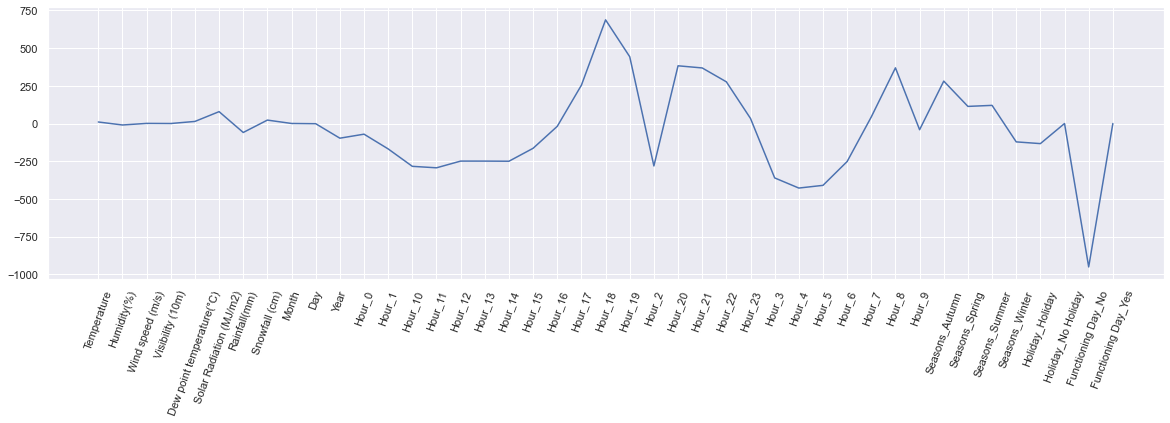

In [585]:
lasso_coef = lasso_r.coef_

plt.plot(range(len(X.columns)), lasso_coef)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=70);


In [586]:
lasso_r.coef_ #Nous constatons que toutes les variables ont été séléctionnées par Lasso, pas de coefs nuls 

array([ 1.01079081e+01, -9.81710020e+00,  7.76393571e-01,  6.56672259e-03,
        1.37943555e+01,  7.86991094e+01, -5.94762962e+01,  2.26824184e+01,
        2.75415774e-01, -1.33412872e+00, -9.73703170e+01, -7.07282896e+01,
       -1.68595885e+02, -2.84123534e+02, -2.93870200e+02, -2.49339378e+02,
       -2.49423264e+02, -2.50249994e+02, -1.64325053e+02, -1.87121478e+01,
        2.54365763e+02,  6.87708051e+02,  4.43058616e+02, -2.81578702e+02,
        3.82882496e+02,  3.68659215e+02,  2.76560424e+02,  3.34576586e+01,
       -3.60894486e+02, -4.28214434e+02, -4.10307609e+02, -2.52281869e+02,
        4.37144852e+01,  3.69342964e+02, -4.11900732e+01,  2.81291516e+02,
        1.13496855e+02,  1.20384768e+02, -1.21840426e+02, -1.33377027e+02,
       -3.46855412e-14, -9.51534374e+02, -2.08716875e-10])

In [613]:
#Nous disposons ainsi de scénarios de solutions pour différentes valeurs de  αα . Mais nous ne savons pas laquelle est la plus performante en prédiction.
#Il existe, tout comme pour la régression Ridge, une classe LassoCV qui permet de
#trouver le  αα  optimal en fonction de la performance prédictive, par validation croisée.

from sklearn.linear_model import LassoCV

model_lasso = LassoCV(alphas=(1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2, 0.1, 0.3, 0.7, 1, 10, 50, 100, 4000,10000),cv=10).fit(X_train, y_train)

pred_test = model_lasso.predict(X_test)

print( 'Alpha chosi par Lasso : ', model_lasso.alpha_)
print('score test :', model_lasso.score(X_test, y_test))
print('mse test :', mean_squared_error(pred_test, y_test))


C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 885943.6856565475, tolerance: 264031.13296400825

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 423382.6224825382, tolerance: 264031.13296400825

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 415331.6627509594, tolerance: 264031.13296400825

C:\Users\lisac\anaconda3\lib\site-packages\sklearn

Alpha chosi par Lasso :  0.1
score test : 0.6626958083776646
mse test : 140536.522402732


C:\Users\lisac\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13779640.13711238, tolerance: 291396.91912704054

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



# Support Vector Machine Regression

In [617]:

parameters = {'gamma':[0.01, 0.025, 0.05, 0.75, 0.1, 0.25, 0.5]}
grid = GridSearchCV(svm.SVR(), parameters, n_jobs=-1, cv=5)
grid.fit(X_train,y_train)
print('Best r2 accuracy : ' + str(round(grid.best_score_ * 100,2)) + '% with Gamma : ' + str(grid.best_estimator_))


C:\Users\lisac\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



Best r2 accuracy : -7.17% with Gamma : SVR(gamma=0.01)
